# Test Matlab Image Alignment

There are images for which the python code fails to generate sensible alignment with either intensity or feature based methods. It's not clear why this is, but to save time, we resorted to using Matlab's image registration toolbox to solve the issue quickly. The only issue is that the output from Matlab needs to be formatted for python.

This notebook checks whether our interpretation of the Matlab image transform is correct.

In [1]:
# Define paths
from dotenv import load_dotenv
from pathlib import Path
import os, sys

load_dotenv()

data_path = Path(os.getenv("local_home")) / 'Task_Switching/head_tracking'

img_path = data_path / 'calibration_images'

In [2]:
import cv2

template_file = "2016-04-29 10_31_56.jpg"
test_file = "2017-03-06 09_22_22.jpg"

template_img = cv2.imread( str(img_path / template_file), cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread( str(img_path / test_file), cv2.IMREAD_GRAYSCALE)

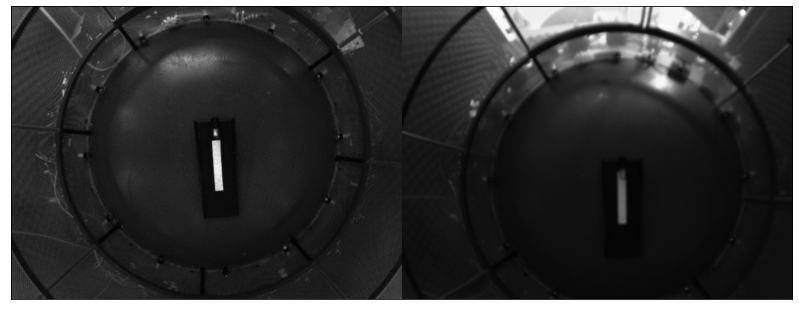

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_combined_img(img_A, img_B, cmap:str='gray'):

    img_combined = np.concatenate((img_A, img_B), axis=1)

    fig, ax = plt.subplots(1,1, **{'figsize':(14,7)})
    ax.imshow(img_combined, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

show_combined_img(template_img, test_img)
plt.show()

## Now correct image

The matlab affine transformation generated by the registerImages.m script is of the format
[r11, r12, 0
 r21, r22, 0
 -tx, -ty, 1]

We can convert this into the 2D format generated by python code:

[r11, r12, tx
 r21, r22, ty]

This is the matrix loaded in the text file below:

In [4]:
align_path = data_path / 'calibration_alignment_intensity'
warp_mat = np.loadtxt( str(align_path / test_file.replace('.jpg','_warp.txt')))
print(warp_mat)

[[ 0.99392051 -0.11009987 48.98249054]
 [ 0.11009987  0.99392051 22.46455574]]


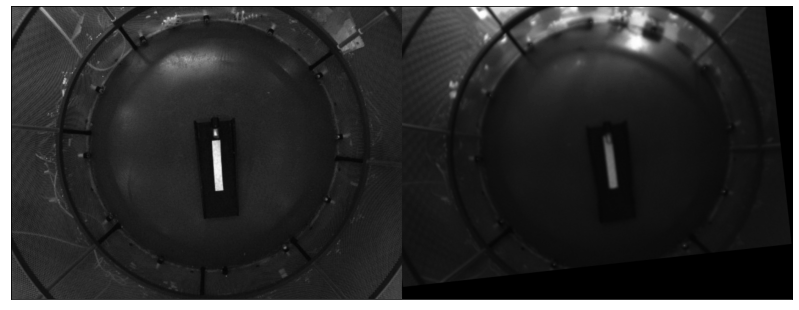

In [5]:
def apply_correction(img, warp_matrix):
    """ Use warpAffine for Translation, Euclidean and Affine """
    
    img_size = img.shape
    img_size = (img_size[1], img_size[0])
    return cv2.warpAffine(img, warp_matrix, img_size, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

align_img = apply_correction(test_img, warp_mat)
show_combined_img(template_img, align_img)
plt.show()

## Webcam Images

We used the webcam to record images alongside TDT samples after the RV2 system broke down. This presents additional challenges to the registration 

We used multimodeal registration, which I thought would give us a homographic transformation; however the registration object generated by the code doesn't seem to give anything beyond the same 2D affine transformation. This was initially stored in a .mat files (one for every calibration image) and then manually exported into text files using the following code (there is no script for this, t'was done in the command window):

``` Matlab
% Define paths
file_path = 'G:\Jumbo_calibration_aligned';
mat_path  = fullfile( file_path, 'mat'); 

% List files containing results from registration (one per calibration image, all relevant calib images have 'resized' in the name)
files = dir( fullfile( mat_path, '*resized.mat'));

% For each result file
for i = 1 : length(files)
    
    % Load and transform
    S = load( fullfile( mat_path, files(i).name), 'reg');
    M = [S.reg.Transformation.T(1:2,1:2), -S.reg.Transformation.T(3,1:2)'];

    % Invert the diagonal components to make scaling parameters compatible with transforms generated by python
    % (Note the cv2.WARP_INVERSE_MAP flag in the cell above)
    M(1,1) = 1 / M(1,1);
    M(2,2) = 1 / M(2,2);

    % Save as text file
    output_file = replace(files(i).name,'.mat','_mat_warp.txt')
    writematrix(M, fullfile( file_path, output_file))
end

```

During registration, we also generated an image showing the quality of alignment for visual inspection, computed according to Matlab:

<img src="./../images/image_registration_2018-02-20_Track_10-20-05_resized.jpg">
<i>Example above from 2018-02-20_Track_10-20-05_resized.jpg</i>

Let's see if we can replicate this work done by matlab, but in Python using the affine transform generated as text file.

In [6]:
# Load images again (just to be explicit)
template_file = "2016-04-29 10_31_56.jpg"
test_file = "2018-02-20_Track_10-20-05_resized.jpg"

template_img = cv2.imread( str(img_path / template_file), cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread( str(img_path / test_file), cv2.IMREAD_GRAYSCALE)

In [16]:
# Load warp data
align_path = data_path / 'calibration_alignment_resized'
warp_mat = np.loadtxt( str(align_path / test_file.replace('.jpg','_mat_warp.txt')), delimiter=',')
print(warp_mat)

[[ 1.33642693e+00  2.04042188e-02 -8.86030609e+01]
 [-2.04042188e-02  1.33642693e+00  2.72631568e+01]]


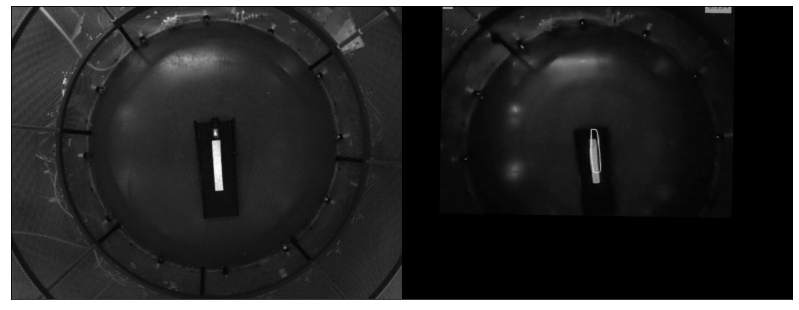

In [17]:
def apply_correction(img, warp_matrix):
    """ Use warpAffine for Translation, Euclidean and Affine """
    
    img_size = img.shape
    img_size = (img_size[1], img_size[0])
    return cv2.warpAffine(img, warp_matrix, img_size, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

align_img = apply_correction(test_img, warp_mat
show_combined_img(template_img, align_img)
plt.show()

In [20]:
1/0.9871

1.013068584743187